In [2]:
#Orignal Author: Austin Lawson
#modified: ic
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist,cdist
from scipy.stats import gaussian_kde
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from collections import defaultdict
from shapely.geometry import Polygon,Point
from operator import itemgetter
import gudhi
import scipy
from scipy import optimize
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
import patsy
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import pandas as pd

In [3]:
#functions for making pd's

def Pers(data):
    """
    Streamlines the gudhi process for computing persistence diagrams via Rips Complex
    @param data: the pointcloud upon which persistence is to be computed
    @output D0,D1: the 0 and 1-dimensional diagrams computed by gudhi
    """
    Complex = gudhi.RipsComplex(data) 
    tree=Complex.create_simplex_tree(max_dimension=2) 
    tree.persistence()
    D0 = tree.persistence_intervals_in_dimension(0) #0-dim diagram
    D1 = tree.persistence_intervals_in_dimension(1) #1-dim diagram
    return D0,D1
def Trans(D):
    """
    Transforms a (birth,death) diagram into a (birth,pers) diagram where pers = death-birth
    @param D: an nx2 array
    @output D_out: the transformed diagram
    """
    D_out = D.copy()
    D_out[:,1] = D_out[:,1]-D_out[:,0]
    return D_out
def Untrans(D):
    """
    Transforms a (birth,pers) diagram into a (birth,death) diagram where pers = death-birth
    @param D: an nx2 array
    @output D_out: the transformed diagram
    """
    D_out = D.copy()
    D_out[:,1] = D_out[:,1]+D_out[:,0]
    return D_out

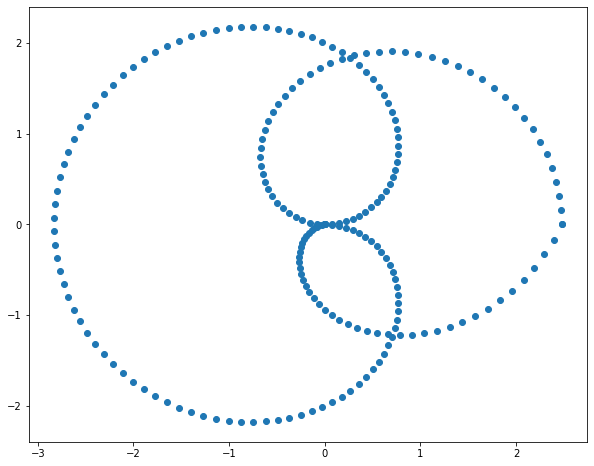

In [4]:
#this cell makes the baseline coorinate map

t1 = np.linspace(0,np.pi,50) #initialize the angled
#r1,x,y all from the definition of the Celtic Knot curve
r1 = 1.75*np.sqrt(2)*np.cos(0.5*t1) 
x1 = r1*np.cos(t1)
y1 = r1*np.sin(t1)
t2 = np.linspace(np.pi,3*np.pi,120) #initialize the angled
#r1,x,y all from the definition of the Celtic Knot curve
r2 = 2*np.sqrt(2)*np.cos(0.5*t2) 
x2 = r2*np.cos(t2)
y2 = r2*np.sin(t2)
t3 = np.linspace(3*np.pi,4*np.pi,45)#initialize the angled
#r1,x,y all from the definition of the Celtic Knot curve
r3 = 3.5/2*np.sqrt(2)*((t3-3*np.pi)/np.pi)**1.4
x3 = r3*np.cos(t3)
y3 = r3*np.sin(t3)
x = np.concatenate((x1,x2,x3))
y = np.concatenate((y1,y2,y3))
coord_mat = np.stack((x,y),axis=1)


plt.figure(figsize = (10,8))
plt.scatter(*coord_mat.T)
plt.savefig('images/knot_true.png')

## ground truth creation

In [6]:
#delete

data_pd = Pers(coord_mat)[0] #compute persistence H0
ground_0 = Trans(data_pd)
data_pd = Pers(coord_mat)[1] #compute persistence H1
ground_1 = Trans(data_pd)

ground_truth = Trans(data_pd)[3:]  #omitting artificail points
print(ground_truth)

[[0.11674082 0.74635811]
 [0.1277873  1.19680247]
 [0.19070255 1.52559192]
 [0.14931025 2.27301151]]


## PD creation
We denote the PD names with respect to the degree of covarience added to baseline dataset. For the project purposes, we are only inteterestined in 1-homological features (loops).

low:Cov=0.005

med:Cov=0.01

hig:Cov=0.1

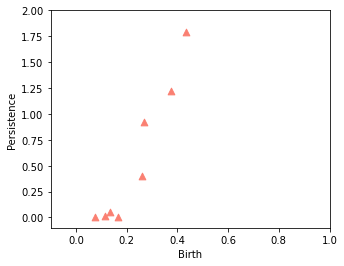

In [5]:
np.random.seed(22) #set seed
point_cloud_low = coord_mat+np.random.multivariate_normal(size = x.shape[0],mean = [0,0], cov = 0.005*np.eye(2)) 
#data_pd = Pers(point_cloud_low)[0] #compute persistence
#pd0_low = Trans(data_pd)
data_pd = Pers(point_cloud_low)[1] #compute persistence
pd1_low = Trans(data_pd)

plt.figure(figsize = (5,4))
plt.scatter(*pd1_low.T,marker="^", c="salmon",label = "Holes",s=45)
#plt.scatter(*pd0_low.T,c="gray",label = "Connected \ncomponents")
plt.xlim(-0.1,1)
plt.ylim(-0.1,2)
plt.xlabel("Birth")
plt.ylabel("Persistence")
#plt.title("low noise Cov=0.005")
plt.savefig('images/PDknot_low.png')

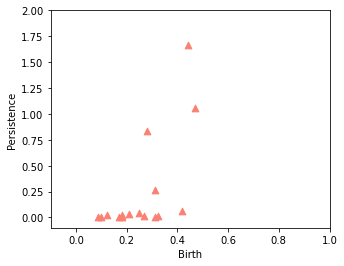

In [6]:
np.random.seed(22) #set seed
point_cloud_med = coord_mat+np.random.multivariate_normal(size = x.shape[0],mean = [0,0], cov = 0.01*np.eye(2)) 
#data_pd = Pers(point_cloud_med)[0] #compute persistence
#pd0_med = Trans(data_pd)
data_pd = Pers(point_cloud_med)[1] #compute persistence
pd1_med = Trans(data_pd)

plt.figure(figsize = (5,4))
plt.scatter(*pd1_med.T,marker="^", c="salmon",label = "Holes",s=45)
#plt.scatter(*pd0_med.T,c="gray",label = "Connected \ncomponents")
plt.xlim(-0.1,1)
plt.ylim(-0.1,2)
plt.xlabel("Birth")
plt.ylabel("Persistence")
#plt.title("medium noise Cov=0.01")
plt.savefig('images/PDknot_med.png')

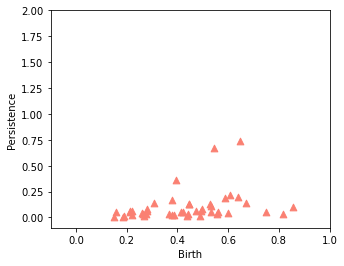

In [7]:
np.random.seed(22) #set seed
point_cloud_hig = coord_mat+np.random.multivariate_normal(size = x.shape[0],mean = [0,0], cov = 0.1*np.eye(2)) 
data_pd = Pers(point_cloud_hig)[0] #compute persistence
pd0_hig = Trans(data_pd)
data_pd = Pers(point_cloud_hig)[1] #compute persistence
pd1_hig = Trans(data_pd)

plt.figure(figsize = (5,4))
plt.scatter(*pd1_hig.T,marker="^", c="salmon",label = "Holes", s=45)
#plt.scatter(*pd0_hig.T,c="gray",label = "Connected \ncomponents")
plt.xlim(-0.1,1)
plt.ylim(-0.1,2)
plt.xlabel("Birth")
plt.ylabel("Persistence")
#plt.title("high noise Cov=0.1")
plt.savefig('images/PDknot_hig.png')

In [8]:
#exportation of PDs
np.save('PDoriginal/PDlownoise', pd1_low)
np.save('PDoriginal/PDmednoise', pd1_med)
np.save('PDoriginal/PDhignoise', pd1_hig)

## More visuals (misc.)

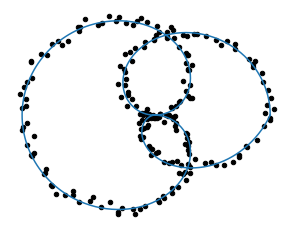

In [12]:
t1 = np.linspace(0,np.pi,200) #initialize the angled
#r1,x,y all from the definition of the Celtic Knot curve
r1 = 1.75*np.sqrt(2)*np.cos(0.5*t1) 
x1 = r1*np.cos(t1)
y1 = r1*np.sin(t1)
t2 = np.linspace(np.pi,3*np.pi,400) #initialize the angled
#r1,x,y all from the definition of the Celtic Knot curve
r2 = 2*np.sqrt(2)*np.cos(0.5*t2) 
x2 = r2*np.cos(t2)
y2 = r2*np.sin(t2)
t3 = np.linspace(3*np.pi,4*np.pi,200)#initialize the angled
#r1,x,y all from the definition of the Celtic Knot curve
r3 = 3.5/2*np.sqrt(2)*((t3-3*np.pi)/np.pi)**1.4
x3 = r3*np.cos(t3)
y3 = r3*np.sin(t3)
x = np.concatenate((x1,x2,x3))
y = np.concatenate((y1,y2,y3))
coord_line = np.stack((x,y),axis=1)

plt.figure(figsize = (5,4))
plt.plot(coord_line[:,0],coord_line[:,1])
plt.scatter(*point_cloud_low.T, color='black',s=20)
plt.axis('off')
plt.savefig('images/data_knot_low.png')

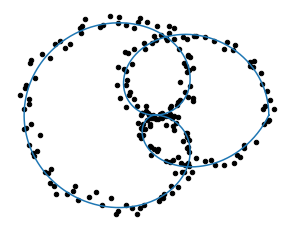

In [13]:
plt.figure(figsize = (5,4))
plt.plot(coord_line[:,0],coord_line[:,1])
plt.scatter(*point_cloud_med.T, color='black', s=20)
plt.axis('off')
plt.savefig('images/data_knot_med.png')

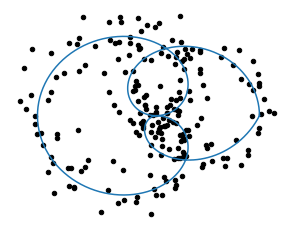

In [14]:
plt.figure(figsize = (5,4))
plt.plot(coord_line[:,0],coord_line[:,1])
plt.scatter(*point_cloud_hig.T, color='black',s=20)
plt.axis('off')

plt.savefig('images/data_knot_hig.png')